![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

## Hidden Markov Models

One of the most important aspects of trading is risk management. Knowing when the market is going to move against you and acting before this happens is the best way to avoid large drawdowns and maximize your Sharpe ratio. The ultimate strategy is buy-low, sell-high. The trouble with this, however, is knowing when low is low and high is high. Hindsight is 20/20, but can we find a way to understand when markets are about to shift from bull to bear?

One possibility is to use a Hidden Markov Model (HMM). These are Markov models where the system is being modeled as a Markov process but whose states are unobserved, or hidden. (Briefly, a Markov process is a stochastic process where the possibility of switching to another state depends only on the current state of the model -- it is history-independent, or memoryless). In a regular Markov model, the state is observable by the user and so the only parameters are the state transition probabilities. For example, in a two-state Markov model, the user is able to know which state the system being modeled is in, and so the only model parameters to be characterized are the probabilities of attaining each state.

As with Kalman filters, there are three main aspects of interest to us:

* Prediction - forecasting future values of the process
* Filtering - estimating the current state of the model
* Smoothing - estimating past states of the model

The salient feature here is prediction as our ultimate goal is to predict the market state. To experiment with this, we used the research notebook to get historical data for SPY and fit a Gaussian, two-state Hidden Markov Model to the data. We built a few functions to build, fit, and predict from our Gaussian HMM.

In [1]:
# Import necessary libraries and get historical data
import numpy as np
from hmmlearn.hmm import GaussianHMM
qb = QuantBook()

symbol = qb.AddEquity('SPY', Resolution.Daily).Symbol

# Fetch history and returns
history = qb.History(symbol, 500, Resolution.Hour)
returns = history.close.pct_change().dropna()

In [2]:
# Define Hidden Markov Model functions
def CreateHMM(algorithm, symbol):
    history = algorithm.History([symbol], 900, Resolution.Daily)
    returns = np.array(history.loc[symbol].close.pct_change().dropna())
    # Reshape returns
    returns = np.array(returns).reshape((len(returns),1))
    # Initialize Gaussian Hidden Markov Model
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(returns)
    print(model.score(returns))
    return model
    
def RefitModel(algorithm, symbol, model):
    history = algorithm.History([symbol], 900, Resolution.Daily)
    returns = np.array(history.loc[symbol].close.pct_change().dropna())
    # Reshape returns
    returns = np.array(returns).reshape((len(returns),1))
    return model.fit(returns)

def PlotStates(algorithm, symbol, model):
    history = algorithm.History([symbol], 900, Resolution.Daily).loc[symbol]
    returns = history.close.pct_change().dropna()

    hidden_states = model.predict(np.array(returns).reshape((len(returns),1)))
    hidden_states = pd.Series(hidden_states, index = returns.index)
    hidden_states.name = 'hidden'
    
    bull = hidden_states.loc[hidden_states.values == 0]
    bear = hidden_states.loc[hidden_states.values == 1]
    plt.figure()
    ax = plt.gca()
    ax.plot(bull.index, bull.values, ".", linestyle='none', c = 'b', label = "Bull Market")
    ax.plot(bear.index, bear.values, ".", linestyle='none', c = 'r', label = "Bear Market")
    plt.title('Hidden States')
    ax.legend()
    plt.show()
    
    df = history.join(hidden_states, how = 'inner')
    df = df[['close', 'hidden']]
    up = pd.Series()
    down = pd.Series()
    mid = pd.Series()
    for tuple in df.itertuples():
        if tuple.hidden == 0:
            x = pd.Series(tuple.close, index = [tuple.Index])
            up = up.append(x)
        else:
            x = pd.Series(tuple.close, index = [tuple.Index])
            down = down.append(x)
    up = up.sort_index()
    down = down.sort_index()
    plt.figure()
    ax = plt.gca()
    ax.plot(up.index, up.values, ".", linestyle='none', c = 'b', label = "Bull Market")
    ax.plot(down.index, down.values, ".", linestyle='none', c = 'r', label = "Bear Market")
    plt.title('SPY')
    ax.legend()
    plt.show()

3078.595332747756


/opt/miniconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


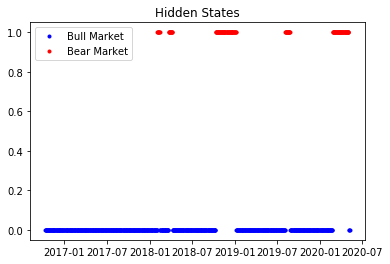

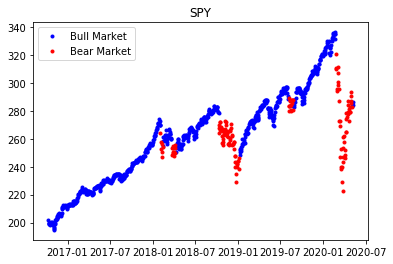

In [3]:
# Build the model and plot good/bad regime states
model = CreateHMM(qb, symbol)
PlotStates(qb, symbol, model)

##### (The specific application of an HMM to SPY returns and as use in risk management is thanks in part to articles on HMM and trading found [here](https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/) and [here](https://www.quantstart.com/articles/hidden-markov-models-for-regime-detection-using-r/).)